<a href="https://colab.research.google.com/github/MrSudhish/training-colab/blob/main/12%7C%7C_language_translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#English → French translation using Encoder–Decoder with Attention

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Dot, Activation, Concatenate

In [ ]:
sentences = [
    "I love deep learning",
    "Deep learning loves me",
    "I love NLP and deep learning"
]

In [ ]:
tokenizer = Tokenizer(num_words=10, oov_token="<OOV>")

In [ ]:
tokenizer.fit_on_texts(sentences)

In [ ]:
word_index = tokenizer.word_index
print("Word Index (word → integer):")
print(word_index)

Word Index (word → integer):
{'<OOV>': 1, 'deep': 2, 'learning': 3, 'i': 4, 'love': 5, 'loves': 6, 'me': 7, 'nlp': 8, 'and': 9}


In [ ]:
sequences = tokenizer.texts_to_sequences(sentences)
print("\nSequences (text → integers):")
print(sequences)


Sequences (text → integers):
[[4, 5, 2, 3], [2, 3, 6, 7], [4, 5, 8, 9, 2, 3]]


In [ ]:
padded = pad_sequences(sequences, padding='post')  # or 'pre'
print("\nPadded Sequences:")
print(padded)


Padded Sequences:
[[4 5 2 3 0 0]
 [2 3 6 7 0 0]
 [4 5 8 9 2 3]]


In [ ]:
english_sentences = ["i love apples", "you like bananas", "she eats bread"]
french_sentences = ["j aime les pommes", "tu aimes les bananes", "elle mange du pain"]

In [ ]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(english_sentences)

In [ ]:
src_sequences = src_tokenizer.texts_to_sequences(english_sentences)
src_word_index = src_tokenizer.word_index
src_vocab_size = len(src_word_index) + 1

In [ ]:
src_word_index

{'i': 1,
 'love': 2,
 'apples': 3,
 'you': 4,
 'like': 5,
 'bananas': 6,
 'she': 7,
 'eats': 8,
 'bread': 9}

In [ ]:
tgt_tokenizer = Tokenizer()
tgt_tokenizer.fit_on_texts(french_sentences)
tgt_sequences = tgt_tokenizer.texts_to_sequences(french_sentences)
tgt_word_index = tgt_tokenizer.word_index
tgt_vocab_size = len(tgt_word_index) + 1

In [ ]:
max_src_len = max(len(s) for s in src_sequences)
max_tgt_len = max(len(s) for s in tgt_sequences)

In [ ]:
src_padded = pad_sequences(src_sequences, maxlen=max_src_len, padding='post')
tgt_padded = pad_sequences(tgt_sequences, maxlen=max_tgt_len, padding='post')

In [ ]:
embed_dim=32

In [ ]:
units=64

In [ ]:
encoder_inputs = Input(shape=(max_src_len,))

In [ ]:
enc_emb=Embedding(src_vocab_size,embed_dim)(encoder_inputs)

In [ ]:
enc_emb

<KerasTensor shape=(None, 3, 32), dtype=float32, sparse=False, ragged=False, name=keras_tensor_1>

In [ ]:
encoder_lstm=LSTM(units,return_state=True,return_sequences=True)

In [ ]:
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)

In [ ]:
encoder_outputs

<KerasTensor shape=(None, 3, 64), dtype=float32, sparse=False, ragged=False, name=keras_tensor_2>

In [ ]:
decoder_inputs = Input(shape=(max_tgt_len,))
dec_emb = Embedding(tgt_vocab_size, embed_dim)(decoder_inputs)
decoder_lstm = LSTM(units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# 👩‍🏫 Training: Teacher Forcing
Teacher Forcing is a method used only during the training phase of Seq2Seq models.
### How It Works
1. Input: The decoder is given the correct target sequence (the ***ground truth translation***), but shifted one position to the right (***prepended with a START token***).

2. Forced Input: ***Instead of using the word it just predicted as the input for the next time step***, the decoder is ***forced to use the correct next word from the ground truth sequence***.

### Example (Translating "I am happy" to "Je suis content"):

* Decoder Input Sequence (Teacher): [<START>, Je, suis, content, <END>]

* Time Step 1: Input is START. Decoder predicts Je.

* Time Step 2: Input is forced to be the correct word, Je. Decoder predicts suis.

* Time Step 3: Input is forced to be the correct word, suis. Decoder predicts content.

### Why It's Used
  1. ***Faster Convergence***: It stabilizes training and allows the model to learn faster because it's always seeing the correct context.

  2. ***Avoids Error Accumulation*** : If the decoder **makes a mistake early in the sequence (e.g., predicts "Nous" instead of "Je")**, the model is not forced to continue translating based on that error. It immediately resets and continues learning from the correct context.



**Connection to Your Code**

The line decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c]) **uses Teacher Forcing. The dec_emb (the embedded decoder_inputs) contains the entire, correct, padded target sequence, meaning the decoder is processing all target words simultaneously during training**.

In [ ]:
attention = Dot(axes=[2, 2])([decoder_outputs, encoder_outputs])

In [ ]:
attention = Activation('softmax')(attention)

In [ ]:
context = Dot(axes=[2,1])([attention, encoder_outputs])

In [ ]:
decoder_combined_context = Concatenate(axis=-1)([context, decoder_outputs])

In [ ]:
output = Dense(tgt_vocab_size, activation='softmax')(decoder_combined_context)

In [ ]:
model = Model([encoder_inputs, decoder_inputs], output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 3, 32)     │        320 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 4, 32)     │        384 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 3, 64),   │     24,832 │ embedding[0][0]   │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 4, 64),   │     24,832 │ embedding_1[0][0… │
│                     │ (None, 64),       │            │ lstm_1[0][1],     │
│                     │ (None, 64)]       │            │ lstm_1[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 4, 3)      │          0 │ lstm_2[0][0],     │
│                     │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 4, 3)      │          0 │ dot[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_1 (Dot)         │ (None, 4, 64)     │          0 │ activation[0][0], │
│                     │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 4, 128)    │          0 │ dot_1[0][0],      │
│ (Concatenate)       │                   │            │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 4, 12)     │      1,548 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 51,916 (202.80 KB)

 Trainable params: 51,916 (202.80 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import numpy as np
model.fit([src_padded, tgt_padded], np.expand_dims(tgt_padded, -1),
          batch_size=1, epochs=100)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0021
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0020
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0021
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0021
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0019
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0019
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0020
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0020
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0019
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0020
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0019
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0019
Epoch 13/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0018
Epoch 14/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0020
Epoch 15/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0019
Epoch 16/100
3/3 ━━

In [ ]:
def translate(sentence):
    seq = src_tokenizer.texts_to_sequences([sentence])
    seq = pad_sequences(seq, maxlen=max_src_len, padding='post')
    output = model.predict([seq, np.zeros((1, max_tgt_len))])
    out_seq = np.argmax(output[0], axis=-1)
    #Inverse Mapping dictionary:-inverts it to map integer ID $\rightarrow$ word. This is essential for converting the predicted IDs back into human-readable text.
    inv_map = {v: k for k, v in tgt_word_index.items()}
    words = [inv_map.get(i, '') for i in out_seq if i > 0]
    return " ".join(words)

print("\n🔹 Translation Demo:")
print("English: i love bananas → French:", translate("i love bananas"))


🔹 Translation Demo:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
English: i love bananas → French: j aime les pommes


# Word Embedding

#One hot Encoding

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
data = {
    'Employee id': [10, 20, 15, 25, 30],
    'Gender': ['M', 'F', 'F', 'M', 'F'],
    'Remarks': ['Good', 'Nice', 'Good', 'Great', 'Nice']
}

In [ ]:
df = pd.DataFrame(data)
print(f"Original Employee Data:\n{df}\n")

Original Employee Data:
   Employee id Gender Remarks
0           10      M    Good
1           20      F    Nice
2           15      F    Good
3           25      M   Great
4           30      F    Nice



In [ ]:
df_encoded = pd.get_dummies(df, columns=['Gender', 'Remarks'], drop_first=True)

print(f"One-Hot Encoded Data (Simplified Pandas Method):\n{df_encoded}\n")

One-Hot Encoded Data (Simplified Pandas Method):
   Employee id  Gender_M  Remarks_Great  Remarks_Nice
0           10      True          False         False
1           20     False          False          True
2           15     False          False         False
3           25      True           True         False
4           30     False          False          True



#BAG OF WORDS
* It **turns** text like sentence, paragraph or document **into a collection of words**
* **Counts how often each word appears** but ignoring the order of the words.
* It does not consider the **order of the words or their grammar** but focuses on counting how often each word appears in the text.

### Step 1: Preprocessing the Text
* Converting the text to lowercase
* Removing non-word characters
* Removing extra spaces

In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
import re
text = """Beans.
I was trying to explain to somebody as we were flying in, that's corn.
That's beans.
And they were very impressed at my agricultural knowledge. Please give it up for Amaury once again
for that outstanding introduction.
I have a bunch of good friends here today,
including somebody who I served with, who is
one of the finest senators in the country, and we're lucky
to have him, your Senator, Dick Durbin is here. I also noticed,
by the way, former Governor Edgar here, who I haven't seen in a long time,
and somehow he has not aged and I have. And it's great to see you, Governor.
I want to thank President Killeen and everybody at the U of I System for making
it possible for me to be here today. And I am deeply honored at the Paul Douglas Award
that is being given to me. He is somebody who set the path for so much outstanding public service here in Illinois. Now, I want to start by addressing the elephant in the room.
 I know people are still wondering why I didn't speak at the commencement."""


In [ ]:
dataset = nltk.sent_tokenize(text)

In [ ]:
dataset

['Beans.',
 "I was trying to explain to somebody as we were flying in, that's corn.",
 "That's beans.",
 'And they were very impressed at my agricultural knowledge.',
 'Please give it up for Amaury once again \nfor that outstanding introduction.',
 "I have a bunch of good friends here today, \nincluding somebody who I served with, who is \none of the finest senators in the country, and we're lucky \nto have him, your Senator, Dick Durbin is here.",
 "I also noticed, \nby the way, former Governor Edgar here, who I haven't seen in a long time, \nand somehow he has not aged and I have.",
 "And it's great to see you, Governor.",
 'I want to thank President Killeen and everybody at the U of I System for making \nit possible for me to be here today.',
 'And I am deeply honored at the Paul Douglas Award \nthat is being given to me.',
 'He is somebody who set the path for so much outstanding public service here in Illinois.',
 'Now, I want to start by addressing the elephant in the room.',
 "I

In [ ]:
processed_dataset = []
for sentence in dataset:
  cleaned_sentence=sentence.lower()

  cleaned_sentence=re.sub(r'\W','',cleaned_sentence).strip()

  cleaned_sentence = re.sub(r'\s+', ' ', cleaned_sentence).strip()

  if cleaned_sentence:
        processed_dataset.append(cleaned_sentence)

In [ ]:
for i, sentence in enumerate(processed_dataset):
    print(f"Sentence {i+1}: {sentence}")

Sentence 1: beans
Sentence 2: iwastryingtoexplaintosomebodyaswewereflyinginthatscorn
Sentence 3: thatsbeans
Sentence 4: andtheywereveryimpressedatmyagriculturalknowledge
Sentence 5: pleasegiveitupforamauryonceagainforthatoutstandingintroduction
Sentence 6: ihaveabunchofgoodfriendsheretodayincludingsomebodywhoiservedwithwhoisoneofthefinestsenatorsinthecountryandwereluckytohavehimyoursenatordickdurbinishere
Sentence 7: ialsonoticedbythewayformergovernoredgarherewhoihaventseeninalongtimeandsomehowhehasnotagedandihave
Sentence 8: anditsgreattoseeyougovernor
Sentence 9: iwanttothankpresidentkilleenandeverybodyattheuofisystemformakingitpossibleformetobeheretoday
Sentence 10: andiamdeeplyhonoredatthepauldouglasawardthatisbeinggiventome
Sentence 11: heissomebodywhosetthepathforsomuchoutstandingpublicservicehereinillinois
Sentence 12: nowiwanttostartbyaddressingtheelephantintheroom
Sentence 13: iknowpeoplearestillwonderingwhyididntspeakatthecommencement


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords
from collections import Counter
import pandas as pd
all_words = []
for sentence in dataset:
    all_words.extend(nltk.word_tokenize(sentence))
stop_words = set(stopwords.words('english'))
filtered_words = [word for word in all_words if word not in stop_words]

In [ ]:
filtered_words

['Beans',
 '.',
 'I',
 'trying',
 'explain',
 'somebody',
 'flying',
 ',',
 "'s",
 'corn',
 '.',
 'That',
 "'s",
 'beans',
 '.',
 'And',
 'impressed',
 'agricultural',
 'knowledge',
 '.',
 'Please',
 'give',
 'Amaury',
 'outstanding',
 'introduction',
 '.',
 'I',
 'bunch',
 'good',
 'friends',
 'today',
 ',',
 'including',
 'somebody',
 'I',
 'served',
 ',',
 'one',
 'finest',
 'senators',
 'country',
 ',',
 "'re",
 'lucky',
 ',',
 'Senator',
 ',',
 'Dick',
 'Durbin',
 '.',
 'I',
 'also',
 'noticed',
 ',',
 'way',
 ',',
 'former',
 'Governor',
 'Edgar',
 ',',
 'I',
 "n't",
 'seen',
 'long',
 'time',
 ',',
 'somehow',
 'aged',
 'I',
 '.',
 'And',
 "'s",
 'great',
 'see',
 ',',
 'Governor',
 '.',
 'I',
 'want',
 'thank',
 'President',
 'Killeen',
 'everybody',
 'U',
 'I',
 'System',
 'making',
 'possible',
 'today',
 '.',
 'And',
 'I',
 'deeply',
 'honored',
 'Paul',
 'Douglas',
 'Award',
 'given',
 '.',
 'He',
 'somebody',
 'set',
 'path',
 'much',
 'outstanding',
 'public',
 'service',

In [ ]:
word_counts = Counter(filtered_words)

In [ ]:
word_counts

Counter({'Beans': 1,
         '.': 13,
         'I': 12,
         'trying': 1,
         'explain': 1,
         'somebody': 3,
         'flying': 1,
         ',': 12,
         "'s": 3,
         'corn': 1,
         'That': 1,
         'beans': 1,
         'And': 3,
         'impressed': 1,
         'agricultural': 1,
         'knowledge': 1,
         'Please': 1,
         'give': 1,
         'Amaury': 1,
         'outstanding': 2,
         'introduction': 1,
         'bunch': 1,
         'good': 1,
         'friends': 1,
         'today': 2,
         'including': 1,
         'served': 1,
         'one': 1,
         'finest': 1,
         'senators': 1,
         'country': 1,
         "'re": 1,
         'lucky': 1,
         'Senator': 1,
         'Dick': 1,
         'Durbin': 1,
         'also': 1,
         'noticed': 1,
         'way': 1,
         'former': 1,
         'Governor': 2,
         'Edgar': 1,
         "n't": 2,
         'seen': 1,
         'long': 1,
         'time': 1,
      

In [ ]:
word_df=pd.DataFrame(word_counts.items(),columns=['Word','Frequency'])

In [ ]:
word_df

,Word,Frequency
0,Beans,1
1,.,13
2,I,12
3,trying,1
4,explain,1
...,...,...
78,people,1
79,still,1
80,wondering,1
81,speak,1


In [ ]:
#Cooocurance matrix
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import defaultdict, Counter
import numpy as np
import pandas as pd

# Download NLTK resources
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
text = """Apple is looking at buying U.K. startup for $1 billion.
          The deal is expected to close by January 2022. Apple is very optimistic about the acquisition."""

In [ ]:
stop_words = set(stopwords.words('english'))
words = word_tokenize(text.lower())
words = [word for word in words if word.isalnum() and word not in stop_words]

In [ ]:
window_size = 2

In [ ]:
co_occurrences = defaultdict(Counter)
for i, word in enumerate(words):
    for j in range(max(0, i - window_size), min(len(words), i + window_size + 1)):
        if i != j:
            co_occurrences[word][words[j]] += 1

In [ ]:
unique_words = list(set(words))

In [ ]:
co_matrix = np.zeros((len(unique_words), len(unique_words)), dtype=int)

In [ ]:
word_index = {word: idx for idx, word in enumerate(unique_words)}
for word, neighbors in co_occurrences.items():
    for neighbor, count in neighbors.items():
        co_matrix[word_index[word]][word_index[neighbor]] = count

In [ ]:
co_matrix_df = pd.DataFrame(co_matrix, index=unique_words, columns=unique_words)

# Display the co-occurrence matrix
co_matrix_df

,close,deal,buying,january,1,looking,apple,expected,acquisition,startup,optimistic,billion
close,0,1,0,1,0,0,1,1,0,0,0,0
deal,1,0,0,0,1,0,0,1,0,0,0,1
buying,0,0,0,0,1,1,1,0,0,1,0,0
january,1,0,0,0,0,0,1,1,0,0,1,0
1,0,1,1,0,0,0,0,0,0,1,0,1
looking,0,0,1,0,0,0,1,0,0,1,0,0
apple,1,0,1,1,0,1,0,0,1,0,1,0
expected,1,1,0,1,0,0,0,0,0,0,0,1
acquisition,0,0,0,0,0,0,1,0,0,0,1,0
startup,0,0,1,0,1,1,0,0,0,0,0,1


# Word2Vec
### 1. CBOW (Continuous Bag of Words)
* Predicts the current word given context words within a specific window.
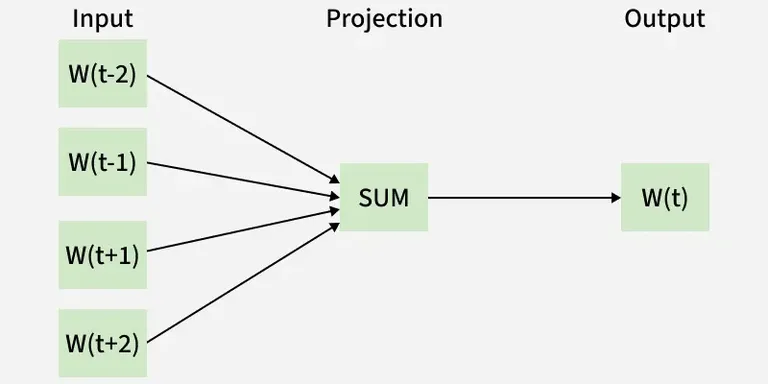

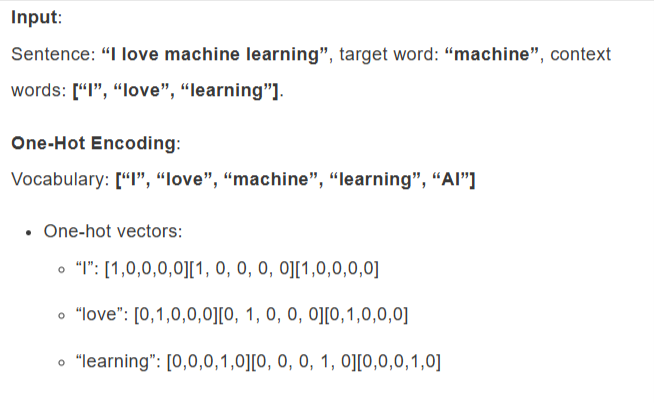

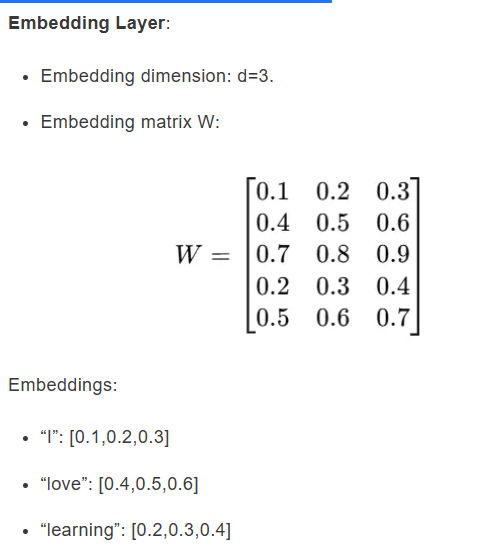

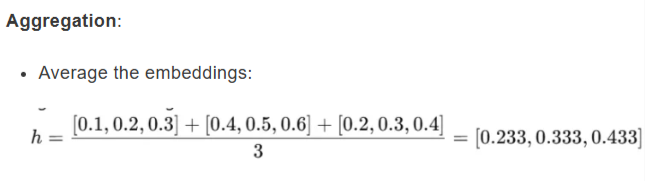

# SKIP GRAM
* Predicts the surrounding context words within specific window given current word.
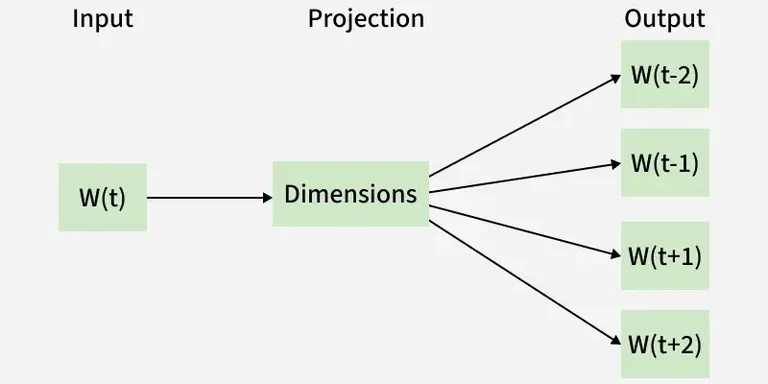

In [ ]:
sentence = "the quick brown fox jumps over the lazy dog"
words = sentence.split()
words

['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']

In [ ]:
vocab = list(set(words))
word_to_id = {w:i for i,w in enumerate(vocab)}
id_to_word = {i:w for w,i in word_to_id.items()}
vocab

['fox', 'lazy', 'jumps', 'the', 'brown', 'over', 'dog', 'quick']

In [ ]:
window = 2
cbow_pairs = []

for i, word in enumerate(words):
    target = word
    context = []
    for j in range(i-window, i+window+1):
        if j != i and 0 <= j < len(words):
            context.append(words[j])
    cbow_pairs.append((context, target))

cbow_pairs

[(['quick', 'brown'], 'the'),
 (['the', 'brown', 'fox'], 'quick'),
 (['the', 'quick', 'fox', 'jumps'], 'brown'),
 (['quick', 'brown', 'jumps', 'over'], 'fox'),
 (['brown', 'fox', 'over', 'the'], 'jumps'),
 (['fox', 'jumps', 'the', 'lazy'], 'over'),
 (['jumps', 'over', 'lazy', 'dog'], 'the'),
 (['over', 'the', 'dog'], 'lazy'),
 (['the', 'lazy'], 'dog')]

In [ ]:
skipgram_pairs = []

for i, word in enumerate(words):
    target = word
    for j in range(i-window, i+window+1):
        if j != i and 0 <= j < len(words):
            skipgram_pairs.append((target, words[j]))

skipgram_pairs

[('the', 'quick'),
 ('the', 'brown'),
 ('quick', 'the'),
 ('quick', 'brown'),
 ('quick', 'fox'),
 ('brown', 'the'),
 ('brown', 'quick'),
 ('brown', 'fox'),
 ('brown', 'jumps'),
 ('fox', 'quick'),
 ('fox', 'brown'),
 ('fox', 'jumps'),
 ('fox', 'over'),
 ('jumps', 'brown'),
 ('jumps', 'fox'),
 ('jumps', 'over'),
 ('jumps', 'the'),
 ('over', 'fox'),
 ('over', 'jumps'),
 ('over', 'the'),
 ('over', 'lazy'),
 ('the', 'jumps'),
 ('the', 'over'),
 ('the', 'lazy'),
 ('the', 'dog'),
 ('lazy', 'over'),
 ('lazy', 'the'),
 ('lazy', 'dog'),
 ('dog', 'the'),
 ('dog', 'lazy')]

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
raw_text = """We are about to study the idea of a deep learning embedding model.
              The continuous bag of words model is simple and powerful."""

In [ ]:
tokens = raw_text.lower().split()


In [ ]:
vocab = set(tokens)
word_to_ix = {word: i for i, word in enumerate(vocab)}
ix_to_word = {i: word for i, word in enumerate(vocab)}
vocab_size = len(vocab)

print(f"Vocab Size: {vocab_size}")
print(f"Vocabulary: {word_to_ix}")

Vocab Size: 21
Vocabulary: {'embedding': 0, 'powerful.': 1, 'bag': 2, 'and': 3, 'is': 4, 'simple': 5, 'the': 6, 'deep': 7, 'model': 8, 'idea': 9, 'learning': 10, 'to': 11, 'words': 12, 'of': 13, 'we': 14, 'about': 15, 'study': 16, 'a': 17, 'are': 18, 'model.': 19, 'continuous': 20}


In [ ]:
# Hyperparameters
EMBEDDING_DIM = 10  # Size of the dense vector
CONTEXT_SIZE = 2    # 2 words to the left, 2 words to the right

In [ ]:
data = []
for i in range(CONTEXT_SIZE, len(tokens) - CONTEXT_SIZE):
    context = (
        [tokens[i - 2], tokens[i - 1], tokens[i + 1], tokens[i + 2]]
    )
    target = tokens[i]
    data.append((context, target))

In [ ]:
print(f"First 3 training pairs: {data[:3]}")

First 3 training pairs: [(['we', 'are', 'to', 'study'], 'about'), (['are', 'about', 'study', 'the'], 'to'), (['about', 'to', 'the', 'idea'], 'study')]


In [ ]:
def make_context_vector(context, word_to_ix):
    idxs = [word_to_ix[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)

In [ ]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW, self).__init__()
        # Matrix A: The Embeddings (Vocab Size x Embed Dim)
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)

        # Matrix B: The Linear Layer (Embed Dim x Vocab Size)
        # Maps the hidden layer back to a probability distribution over the vocab
        self.linear = nn.Linear(embedding_dim, vocab_size)

    def forward(self, inputs):
        # 1. Look up embeddings for context words
        # Shape: (4, 10) -> 4 words, dimension 10
        embeds = self.embeddings(inputs)

        # 2. Sum the vectors (The core of CBOW)
        # We squash the 4 context vectors into 1 vector representing the context
        # Shape: (1, 10)
        sum_embeds = torch.sum(embeds, dim=0).view(1, -1)

        # 3. Pass through Linear Layer
        out = self.linear(sum_embeds)

        # 4. Softmax to get probabilities
        log_probs = F.log_softmax(out, dim=1)
        return log_probs


In [ ]:
# Initialize Model
model = CBOW(vocab_size, EMBEDDING_DIM)

# Loss function and Optimizer
loss_function = nn.NLLLoss() # Negative Log Likelihood
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [ ]:
print("\n--- Starting Training ---")
for epoch in range(75):
    total_loss = 0
    for context, target in data:
        # Step 1: Prepare inputs
        context_idxs = make_context_vector(context, word_to_ix)

        # Step 2: Clear gradients
        model.zero_grad()

        # Step 3: Forward Pass
        log_probs = model(context_idxs)

        # Step 4: Calculate Loss
        # We need the index of the target word
        target_idx = torch.tensor([word_to_ix[target]], dtype=torch.long)
        loss = loss_function(log_probs, target_idx)

        # Step 5: Backward Pass (Update Weights)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


--- Starting Training ---
Epoch 10, Loss: 37.4194
Epoch 20, Loss: 34.5724
Epoch 30, Loss: 32.0863
Epoch 40, Loss: 29.8913
Epoch 50, Loss: 27.9335
Epoch 60, Loss: 26.1733
Epoch 70, Loss: 24.5805


In [ ]:
#We are about to study the idea of a deep learning embedding model.
#The continuous bag of words model is simple and powerful.
test_context = ["deep", "learning", "words", "model"]
context_vector = make_context_vector(test_context, word_to_ix)

In [ ]:
# Predict
with torch.no_grad():
    prediction = model(context_vector)

# Get the index of the max probability
predicted_index = torch.argmax(prediction).item()
predicted_word = ix_to_word[predicted_index]

print(f"Context: {test_context}")
print(f"Prediction: '{predicted_word}'")

# ==========================================
# 5. Extracting Embeddings
# ==========================================
# To get the vector for a specific word, e.g., 'deep'
word_vec = model.embeddings(torch.tensor([word_to_ix['deep']]))
print(f"\nLearned Vector for 'deep':\n{word_vec}")

Context: ['deep', 'learning', 'words', 'model']
Prediction: 'of'

Learned Vector for 'deep':
tensor([[-0.1255, -0.6753, -1.1075,  0.0607, -1.6217,  1.3353,  0.3259,  0.1093,
         -0.6349,  0.7290]], grad_fn=<EmbeddingBackward0>)
